In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
import datetime
from sklearn.metrics import fbeta_score
import lightgbm as lgb

In [3]:
class Config:
    pass
config = pd.read_pickle('config.pkl')
data_path = config.data_path
feature_path = config.feature_path
print(dir(config))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'data_path', 'feature_dict', 'feature_path', 'model_features', 'result_path', 'single_module_validation_indice_set', 'trade_train_size', 'train_2_6_index']


In [4]:
config.feature_dict

{'llc_user_habbit': ['fail_-1_count_30',
  'fail_-1_count_360',
  'fail_-1_rate_30',
  'fail_-1_rate_360',
  'fail_-2_count_30',
  'fail_-2_count_360',
  'fail_-2_rate_30',
  'fail_-2_rate_360',
  'is_scan_count_30',
  'is_scan_count_360',
  'is_scan_rate_30',
  'is_scan_rate_360',
  'log_from_10_count_30',
  'log_from_10_count_360',
  'log_from_10_rate_30',
  'log_from_10_rate_360',
  'log_from_11_count_30',
  'log_from_11_count_360',
  'log_from_11_rate_30',
  'log_from_11_rate_360',
  'log_from_1_count_30',
  'log_from_1_count_360',
  'log_from_1_rate_30',
  'log_from_1_rate_360',
  'log_from_21_count_30',
  'log_from_21_count_360',
  'log_from_21_rate_30',
  'log_from_21_rate_360',
  'log_from_2_count_30',
  'log_from_2_count_360',
  'log_from_2_rate_30',
  'log_from_2_rate_360',
  'period_0_login_rate_30',
  'period_0_login_rate_360',
  'period_0_login_times_30',
  'period_0_login_times_360',
  'period_0_trade_rate_30',
  'period_0_trade_rate_360',
  'period_0_trade_times_30',
  '

In [5]:
features =   (config.feature_dict['trade_detail_feature']+
              config.feature_dict['recent_login_detail']+
              config.feature_dict['trade_and_recent_login_comparing']+
              config.feature_dict['login_trade_hist_stats']+
              config.feature_dict['llc_user_habbit']
             )
feature_sequence_list = []
for feature in features:
    feature_sequence_list.append(pd.read_pickle(feature_path+feature+'.pkl').reshape(-1,1))

In [6]:
trade_tt_mat = np.hstack(feature_sequence_list)

### Setting up model and label

In [7]:
validation_tuple_list = config.single_module_validation_indice_set
train_labels = pd.read_pickle(data_path+'trade_train_label.pkl')

In [9]:
#model define
def f_beta_01(preds, train_data):
    labels  = train_data.get_label()
    return 'fbeta_score_01',fbeta_score(labels, preds > 0.5,0.1),True

    
#for binary
def runLGBM(train_X, train_y, test_X, test_y=None, feature_names=None,
           seed_val=0, num_rounds=10000,watch_dict = None,max_bin=50000,
           num_leaves=16,early_stop=64,verbose=True,eta=0.1,
           bagging_fraction = 0.75 , feature_fraction = 0.75,feval = None,metric = 'binary_logloss',
           train_sample_weight = None):
    
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': num_leaves,
        'learning_rate': eta,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'bagging_freq': 5,
        'verbose': verbose,
        'is_unbalance':False
    }
    
    num_rounds = num_rounds

    #plst = list(param.items())
    lgbtrain = lgb.Dataset(train_X, label=train_y,max_bin=max_bin,feature_name=feature_names,weight =train_sample_weight)

    if test_y is not None:
        lgbtest = lgb.Dataset(test_X, label=test_y,max_bin=max_bin,feature_name=feature_names)
        watchlist = [lgbtrain,lgbtest]
        watchlist_name=['train','test']
        model = lgb.train(params, lgbtrain, num_rounds, watchlist,watchlist_name, early_stopping_rounds=early_stop,\
                         evals_result = watch_dict,verbose_eval=verbose,feval = feval)
    else:
        #lgbtest = lgb.Dataset(test_X,feature_name=feature_names)
        model = lgb.train(params, lgbtrain, num_rounds)

    pred_test_y = model.predict(test_X)
    return pred_test_y, model

In [10]:
cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_mat[train_indice], trade_tt_mat[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.94953	test's auc: 0.931324
[200]	train's auc: 0.981938	test's auc: 0.970328
[300]	train's auc: 0.993573	test's auc: 0.974086
[400]	train's auc: 0.997442	test's auc: 0.972833
Early stopping, best iteration is:
[313]	train's auc: 0.994694	test's auc: 0.97434
f_beta score for the turn 1 is 0.869752421959
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.970026	test's auc: 0.852258
[200]	train's auc: 0.987912	test's auc: 0.895263
[300]	train's auc: 0.995884	test's auc: 0.907942
[400]	train's auc: 0.998746	test's auc: 0.915492
[500]	train's auc: 0.9995	test's auc: 0.920535
Early stopping, best iteration is:
[495]	train's auc: 0.999472	test's auc: 0.920899
f_beta score for the turn 2 is 0.487922705314
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.961853	test's auc: 0.918301
[200]	train's auc: 0.985231	test's auc: 0.949193
[300]	train's au

### Check feature importance

In [14]:
feature_importance_total = np.zeros(trade_tt_mat.shape[1])
for model in models:
    feature_importance_total+=model.feature_importance('gain')
sorted_feature_importacne = sorted(zip(features,feature_importance_total),key = lambda x : x[1],reverse = True)

In [15]:
sorted_feature_importacne

[('login_distance_0', 50709.736062905082),
 ('trade_login_success_rate_1', 20229.245500364759),
 ('timelong_std_1', 18605.61123097386),
 ('login_success_rate_360', 17914.272142326521),
 ('trade_times_1', 17723.393296601691),
 ('type_3_count_30', 14981.732057664793),
 ('period_4_login_rate_30', 13590.837970573823),
 ('trade_login_rate_1', 13190.74255956078),
 ('fail_-2_rate_30', 11404.412112390713),
 ('period_4_login_rate_360', 11176.144494972139),
 ('type_login_0', 10630.37517474471),
 ('timelong_max_1', 10509.958701540465),
 ('login_distance_1', 10095.681628152193),
 ('period_3_trade_rate_360', 10042.64837547579),
 ('timelong_min_15', 8886.5760329398545),
 ('timelong_min_30', 8258.0454501211243),
 ('type_3_rate_30', 7754.6193725776466),
 ('success_1_rate_30', 7109.4723406564062),
 ('period_3_login_rate_360', 6853.4899286608124),
 ('timelong_std_3', 6018.5972114618271),
 ('period_4_trade_rate_360', 5527.182967360829),
 ('trade_times_360', 5369.116794995025),
 ('timelong_med_360', 5143.

<Container object of 268 artists>

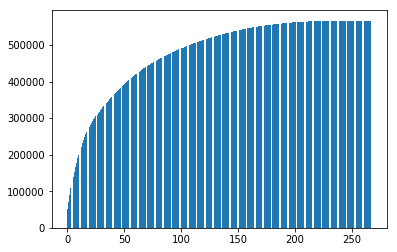

In [16]:
%matplotlib inline
all_importance = [x[1] for x in sorted_feature_importacne]
x = pd.Series(all_importance).sort_values(ascending = False).cumsum()
plt.bar(range(len(x)),x)

考虑在200左右截断

In [17]:
top_200_features =  [x[0] for x in sorted_feature_importacne][0:200]
top_200_feature_ori_index = [features.index(x) for x in top_200_features]
trade_tt_mat_top_200 = trade_tt_mat[:,top_200_feature_ori_index]

In [20]:
#top 200 features
cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_mat_top_200[train_indice], trade_tt_mat_top_200[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=top_200_features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.947358	test's auc: 0.932782
[200]	train's auc: 0.981811	test's auc: 0.971998
[300]	train's auc: 0.993629	test's auc: 0.975037
[400]	train's auc: 0.997397	test's auc: 0.974286
Early stopping, best iteration is:
[315]	train's auc: 0.995063	test's auc: 0.975476
f_beta score for the turn 1 is 0.846501553819
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.969772	test's auc: 0.859679
[200]	train's auc: 0.987604	test's auc: 0.892349
[300]	train's auc: 0.995769	test's auc: 0.906811
[400]	train's auc: 0.99872	test's auc: 0.91448
[500]	train's auc: 0.999473	test's auc: 0.918667
[600]	train's auc: 0.999789	test's auc: 0.918796
[700]	train's auc: 0.999925	test's auc: 0.920539
Early stopping, best iteration is:
[692]	train's auc: 0.999917	test's auc: 0.921263
f_beta score for the turn 2 is 0.441185647426
Training until validation scores don't improve for 100 rounds.
[100]	train's 

In [21]:
#top 200 features,try better fraction result
cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_mat_top_200[train_indice], trade_tt_mat_top_200[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=top_200_features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None,feature_fraction = 0.5)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.956739	test's auc: 0.945924
[200]	train's auc: 0.981061	test's auc: 0.970419
[300]	train's auc: 0.991082	test's auc: 0.974131
[400]	train's auc: 0.996978	test's auc: 0.975147
Early stopping, best iteration is:
[311]	train's auc: 0.992821	test's auc: 0.975357
f_beta score for the turn 1 is 0.846791096916
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.970283	test's auc: 0.862577
[200]	train's auc: 0.986384	test's auc: 0.897736
[300]	train's auc: 0.995204	test's auc: 0.911235
[400]	train's auc: 0.998594	test's auc: 0.92011
[500]	train's auc: 0.999345	test's auc: 0.92402
[600]	train's auc: 0.999724	test's auc: 0.924872
Early stopping, best iteration is:
[538]	train's auc: 0.999549	test's auc: 0.925627
f_beta score for the turn 2 is 0.472698907956
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.963922	test's auc: 0.925899
[200]	train's 